<a href="https://colab.research.google.com/github/Lucs1590/USeS-BPCA/blob/main/notebooks/u_net_bpca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-net-like with Data Science Bowl

## Imports

In [1]:
import os
import json
import time
import math
import random

from datetime import datetime
from pathlib import Path
from typing import Tuple

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    CSVLogger,
    TensorBoard,
    ReduceLROnPlateau,
    Callback
)

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from IPython.display import Image
from IPython.display import display as display_ipython


2023-12-02 14:23:59.914041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 14:23:59.937644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 14:24:00.329885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if 'content' in os.getcwd():
    COLAB = True
    from google.colab import drive
    drive.mount('/content/gdrive')
    RESOURCES_DIR = f'{os.path.join(os.getcwd(), os.pardir)}/resources/'
else:
    COLAB = False
    RESOURCES_DIR = f'{(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))}/resources/'

np.random.seed(77)
tf.random.set_seed(77)


## Constant Variables

In [26]:
RESOURCES_DIR = RESOURCES_DIR.replace('..', '').replace('//', '/')
None if os.path.isdir(RESOURCES_DIR) else os.mkdir(RESOURCES_DIR)
LOGS_DIR = f'{RESOURCES_DIR}logs/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
None if os.path.isdir(LOGS_DIR) else os.makedirs(LOGS_DIR, exist_ok=True)

TRAIN_PATH = '/home/hinton/brito/datasets/ds_bowl/stage1_train'
TEST_PATH = '/home/hinton/brito/datasets/ds_bowl/stage1_test'

MODEL_NAME = 'bpca_unetlike'

BATCH_SIZE = 64
BUFFER_SIZE = 1000

HEIGHT, WIDTH = 256, 256
IMG_CHANNELS = 3

NUM_CLASSES = 3  # background, foreground, boundary
NUM_EPOCHS = 500
VAL_SUBSPLITS = 5


In [4]:
RESOURCES_DIR


'/home/hinton/brito/resources/'

## Dataset
Download and applying transformations to the dataset.


In [24]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [28]:
X_train = np.zeros((len(train_ids), HEIGHT, WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), HEIGHT, WIDTH, 1), dtype=bool)

In [30]:
for n, id_ in enumerate(train_ids):
    path = f'{TRAIN_PATH}/{id_}'
    img = keras.preprocessing.image.load_img(f'{path}/images/{id_}.png', target_size=(HEIGHT, WIDTH))
    X_train[n] = img
    mask = np.zeros((HEIGHT, WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(f'{path}/masks/'))[2]:
        mask_ = keras.preprocessing.image.load_img(f'{path}/masks/{mask_file}', target_size=(HEIGHT, WIDTH), color_mode='grayscale')
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

In [25]:
TRAIN_LENGTH = len(train_ids)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

TEST_LENTH = len(test_ids) - int(len(test_ids)*0.2)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
LEARNING_RATE = 1e-4

In [12]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(
        input_image,
        (HEIGHT, WIDTH),
        method="nearest"
    )
    input_mask = tf.image.resize(input_mask, (HEIGHT, WIDTH), method="nearest")

    return input_image, input_mask


In [13]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    # color augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_saturation(input_image, 0, 2)
        input_image = tf.image.random_brightness(input_image, 0.35)
        input_image = tf.image.random_contrast(input_image, 0, 2)

    # rotation augmentation
    if tf.random.uniform(()) > 0.5:
        random_degree = random.uniform(-25, 25)
        input_image = tf.image.rot90(input_image, k=int(random_degree // 90))
        input_mask = tf.image.rot90(input_mask, k=int(random_degree // 90))

    # Gausian blur augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.resize(
            input_image,
            (256, 256),
            method="nearest"
        )
        input_image = tf.image.resize(
            input_image,
            (128, 128),
            method="nearest"
        )
        input_image = tf.image.resize(
            input_image,
            (256, 256),
            method="nearest"
        )
    
    return input_image, input_mask

In [14]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


In [21]:
def load_image_train(datapoint):
    input_image = datapoint["image_left"]
    input_mask = datapoint["segmentation_label"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [19]:
def load_image_test(datapoint):
    input_image = datapoint["image_left"]
    input_mask = datapoint["segmentation_label"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [18]:
dataset["train"]

<_PrefetchDataset element_spec={'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}>

In [22]:
train_dataset = dataset["train"].map(
    load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(
    load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

print(train_dataset)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))>


In [23]:
train_batches = train_dataset.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)


In [24]:
def display(display_list, name=None):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")

    if name:
        plt.savefig(f'{RESOURCES_DIR}prediction_{random.randint(0, 1000)}.png', dpi=300, format="png")

    plt.show()


2023-11-17 22:07:52.246174: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


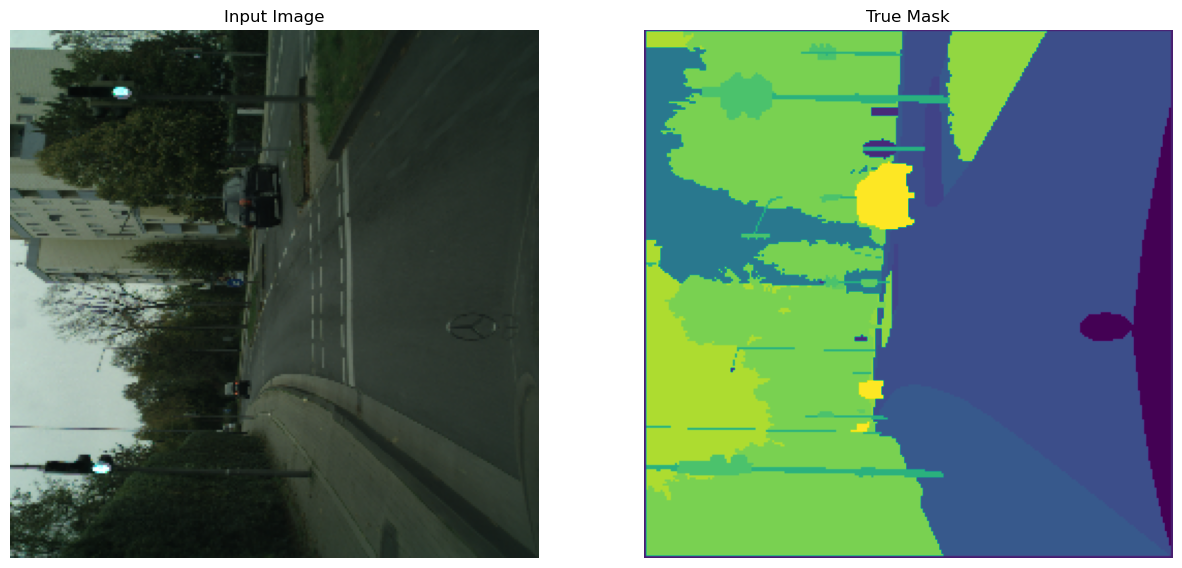

In [25]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])


## BPCA

In [26]:
class BPCAPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1, expected_shape=None, **kwargs):
        super(BPCAPooling, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components
        self.expected_shape = expected_shape

        self.patch_size = [1, self.pool_size, self.pool_size, 1]
        self.strides = [1, self.stride, self.stride, 1]

    def build(self, input_shape):
        super(BPCAPooling, self).build(input_shape)

    @tf.function
    def bpca_pooling(self, feature_map):
        # Compute the region of interest
        h, w, c = self.expected_shape  # block_height, block_width, block_channels
        d = c // (self.pool_size * self.pool_size)  # block_depth

        # Create blocks (patches)
        data = tf.reshape(feature_map, [1, h, w, c])
        patches = tf.image.extract_patches(
            images=data,
            sizes=self.patch_size,
            strides=self.strides,
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(
            patches,
            [h*w*d, self.pool_size * self.pool_size]
        )

        # Normalize the data by subtracting the mean and dividing by the standard deviation
        mean = tf.reduce_mean(patches, axis=0)
        std = tf.math.reduce_std(patches, axis=0)
        patches = (patches - mean) / std
        patches = tf.where(tf.math.is_nan(patches), 0.0, patches)

        # Perform the Singular Value Decomposition (SVD) on the data
        _, _, v = tf.linalg.svd(patches)

        # Extract the first n principal components from the matrix v
        pca_components = v[:, :self.n_components]

        # Perform the PCA transformation on the data
        transformed_patches = tf.matmul(patches, pca_components)
        return tf.reshape(transformed_patches, [h // self.pool_size, w // self.pool_size, c])

    def call(self, inputs):
        pooled = tf.vectorized_map(self.bpca_pooling, inputs)
        return pooled


In [27]:
class BPCAUnpooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1, expected_shape=None, **kwargs):
        super(BPCAUnpooling, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components
        self.expected_shape = expected_shape

        self.patch_size = [1, self.pool_size, self.pool_size, 1]
        self.strides = [1, self.stride, self.stride, 1]

    def build(self, input_shape):
        super(BPCAUnpooling, self).build(input_shape)

    @tf.function
    def bpca_unpooling(self, transformed_patches):
        # Compute the region of interest
        h, w, c = self.expected_shape  # block_height, block_width, block_channels

        # Perform the reverse PCA transformation on the transformed patches
        _, _, v = tf.linalg.svd(transformed_patches, compute_uv=True)
        pca_components = tf.linalg.matrix_transpose(v[:, :self.n_components])
        original_patches = tf.matmul(
            transformed_patches,
            pca_components[..., tf.newaxis]
        )

        # Revert the PCA transformation by multiplying by the standard deviation and adding the mean
        mean = tf.reduce_mean(original_patches, axis=0)
        std = tf.math.reduce_std(original_patches, axis=0)
        original_patches = (original_patches * std) + mean

        # Reconstruct the original data
        original_patches = tf.where(
            tf.math.is_nan(original_patches),
            0.0,
            original_patches
        )

        # Adjust the reshaping to achieve upsampling
        original_patches = tf.reshape(
            original_patches,
            [-1, h, w, c]
        )
        return original_patches

    def call(self, inputs):
        return self.bpca_unpooling(inputs)

## U-net-like architecture


In [28]:
def get_layers_nmb_unetlike_pooling(number):
    if number == 32:
        return (256, 256, 32)
    if number == 64:
        return (128, 128, 64)
    if number == 128:
        return (64, 64, 128)
    if number == 256:
        return (32, 32, 256)
    if number == 512:
        return (16, 16, 512)
    else:
        return (0, 0, 0)


def get_layers_nmb_unetlike_unpooling(number):
    if number == 256:
        return (32, 32, 256)
    if number == 128:
        return (64, 64, 128)
    if number == 64:
        return (128, 128, 64)
    if number == 32:
        return (256, 256, 32)


In [36]:
def get_unetlike_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(2, strides=2, padding="same")(x)
        # x = BPCAPooling(pool_size=2, stride=2, expected_shape=get_layers_nmb_unetlike_pooling(filters))(x)
        # print(filters, x.shape)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)
        # x = BPCAUnpooling(pool_size=2, stride=2, expected_shape=get_layers_nmb_unetlike_unpooling(filters))(x)
        print(filters, x.shape)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        # residual = BPCAUnpooling(pool_size=2, stride=2, expected_shape=get_layers_nmb_unetlike_unpooling(filters))(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


## U-Net architecture

In [30]:
def get_layers_nmb_unet_pooling(number):
    if number == 64:
        return (256, 256, 64)
    if number == 128:
        return (128, 128, 128)
    if number == 256:
        return (64, 64, 256)
    if number == 512:
        return (32, 32, 512)
    else:
        return (0, 0, 0)


def get_layers_nmb_unet_unpooling(number):
    if number == 64:
        return (256, 256, 64)
    if number == 128:
        return (128, 128, 128)
    if number == 256:
        return (64, 64, 256)
    if number == 512:
        return (32, 32, 512)
    else:
        return (0, 0, 0)

In [31]:
def get_unet_model(img_size, num_classes):
    def convolution_block(input, num_filters):
        x = layers.Conv2D(num_filters, 3, padding='same')(input)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(num_filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        return x

    def encoder_block(input, num_filters):
        conv_layer = convolution_block(input, num_filters)
        pooling = layers.MaxPooling2D((2, 2))(conv_layer)
        # pooling = BPCAPooling(pool_size=2, stride=2, expected_shape=get_layers_nmb_unet_pooling(num_filters))(conv_layer)
        return conv_layer, pooling

    def decoder_block(input, skip_features, num_filters):
        # x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input)
        x = BPCAUnpooling(pool_size=2, stride=2, expected_shape=get_layers_nmb_unet_pooling(num_filters))(input)
        print(x.shape)
        x = layers.Concatenate()([x, skip_features])
        x = convolution_block(x, num_filters)
        return x

    inputs = layers.Input(shape=img_size + (3,))
    filters = [64, 128, 256, 512]
    saved_layers = []

    pooling = inputs
    for filter in filters:
        conv_layer, pooling = encoder_block(pooling, filter)
        saved_layers.append(conv_layer)

    conv_block = convolution_block(pooling, 1024)

    deconv_layer = conv_block
    for filter in reversed(filters):
        conv_layer = saved_layers.pop()
        deconv_layer = decoder_block(deconv_layer, conv_layer, filter)

    outputs = layers.Conv2D(num_classes, 3, padding='same',
                            activation='softmax')(deconv_layer)

    model = keras.Model(inputs, outputs, name='UNet')
    return model


## Metrics

In [32]:
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    union = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - intersection
    return tf.reduce_mean(intersection / union)


In [33]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth),axis=0)
    return dice


In [34]:
def pixel_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.dtypes.float64)
    y_pred = tf.cast(y_pred, tf.dtypes.float64)
    return tf.reduce_mean(tf.cast(
        tf.equal(y_true, y_pred),
        tf.float32
    ))


## Model Selection

In [37]:
model = get_unetlike_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)
# model = get_unet_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)
# model = load_model("/Volumes/SSD/Mestrado/Dissertacao/resources/max_unet_500_miou/max_unet_miou.h5", custom_objects={'mean_iou': mean_iou, 'dice_coefficient': dice_coefficient})
# model_history = pd.read_csv('/home/hinton/brito/models/max_unetlike.csv')
# model_history.head()


256 (None, 32, 32, 256)
128 (None, 64, 64, 128)
64 (None, 128, 128, 64)
32 (None, 256, 256, 32)


In [38]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 128, 128, 32)         128       ['conv2d_7[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 128, 128, 32)         0         ['batch_normalization_15[0

In [39]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_2 True
1 conv2d_7 True
2 batch_normalization_15 True
3 activation_15 True
4 activation_16 True
5 separable_conv2d_6 True
6 batch_normalization_16 True
7 activation_17 True
8 separable_conv2d_7 True
9 batch_normalization_17 True
10 bpca_pooling_3 True
11 conv2d_8 True
12 add_6 True
13 activation_18 True
14 separable_conv2d_8 True
15 batch_normalization_18 True
16 activation_19 True
17 separable_conv2d_9 True
18 batch_normalization_19 True
19 bpca_pooling_4 True
20 conv2d_9 True
21 add_7 True
22 activation_20 True
23 separable_conv2d_10 True
24 batch_normalization_20 True
25 activation_21 True
26 separable_conv2d_11 True
27 batch_normalization_21 True
28 bpca_pooling_5 True
29 conv2d_10 True
30 add_8 True
31 activation_22 True
32 conv2d_transpose_8 True
33 batch_normalization_22 True
34 activation_23 True
35 conv2d_transpose_9 True
36 batch_normalization_23 True
37 up_sampling2d_1 True
38 up_sampling2d True
39 conv2d_11 True
40 add_9 True
41 activation_24 True
42 conv2d_transpose

In [ ]:
# plot_model(
#     model,
#     to_file=f'{RESOURCES_DIR}model.png',
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir='TB'
# )


## Training & Testing

In [40]:
optimizer = Adam(learning_rate=LEARNING_RATE)
# optimizer = SGD(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", dice_coefficient, mean_iou]
)


Callbacks

In [41]:
def to_rgb(img: np.array):
    img = np.asarray(img, dtype=np.float32)

    channels = img.shape[-1]
    if channels == 1:
        img = np.expand_dims(img, axis=-1)
        img = np.tile(img, (1, 1, 3))

    elif channels == 2:
        img = np.concatenate((img, img[..., :1]), axis=-1)

    elif channels > 3:
        img = img[..., :3]

    img = np.clip(img, 0, 1)

    return img


def crop_image_and_label_to_shape(shape: Tuple[int, int, int]) -> callable:
    def crop(image: np.ndarray, label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        cropped_image = crop_to_shape(image, shape)
        cropped_label = crop_to_shape(label, shape)
        return cropped_image, cropped_label

    return crop


def crop_to_shape(data: np.ndarray, shape: Tuple[int, int, int]) -> np.ndarray:
    assert len(
        data.shape) == 3, "Data must have 3 dimensions (height, width, channels)."
    assert data.shape[0] >= shape[0] and data.shape[1] >= shape[1], "Data must be larger than the desired shape."

    diff_nx = (data.shape[0] - shape[0])
    diff_ny = (data.shape[1] - shape[1])

    if diff_nx == 0 and diff_ny == 0:
        return data

    offset_nx_left = diff_nx // 2
    offset_nx_right = diff_nx - offset_nx_left
    offset_ny_left = diff_ny // 2
    offset_ny_right = diff_ny - offset_ny_left

    cropped = data[offset_nx_left:(-offset_nx_right),
                   offset_ny_left:(-offset_ny_right)]

    assert cropped.shape[0] == shape[0], "Cropped data has incorrect height."
    assert cropped.shape[1] == shape[1], "Cropped data has incorrect width."
    assert cropped.shape[2] == shape[2], "Cropped data has incorrect number of channels."

    return cropped


class TensorBoardImageSummary(Callback):
    def __init__(self, name, logdir: str, dataset: tf.data.Dataset, max_outputs: int = None):
        super().__init__()
        self.name = name
        self.logdir = f"{Path(logdir)}/summaries"
        self.max_outputs = max_outputs or dataset.cardinality().numpy()
        self.dataset = dataset.take(self.max_outputs)
        self.file_writer = tf.summary.create_file_writer(self.logdir)

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.dataset.batch(1))
        self._log_histograms(epoch, predictions)
        self._log_image_summaries(epoch, predictions)
        self.file_writer.flush()

    def _log_image_summaries(self, epoch, predictions):
        images, labels = self._get_cropped_images_labels(predictions.shape[1:])
        output = self._combine_to_image(images, labels, predictions)
        # change output to have only 3 channels. We need to change here to see different outputs
        # chanels. The output is a 9D array, where the first 3 channels are the input image, the
        # next 3 channels are the ground truth and the last 3 channels are the prediction.
        output = output[..., 6:9]

        with self.file_writer.as_default():
            tf.summary.image(
                self.name,
                output,
                step=epoch,
                max_outputs=self.max_outputs
            )

    def _get_cropped_images_labels(self, shape):
        cropped_data = self.dataset.map(crop_image_and_label_to_shape(shape))
        cropped_images, cropped_labels = list(
            cropped_data.take(self.max_outputs).batch(self.max_outputs)
        )[0]
        return cropped_images.numpy(), cropped_labels.numpy()

    def _combine_to_image(self, images, labels, predictions):
        mask = predictions[..., :1] if predictions.shape[-1] == 2 else np.argmax(
            predictions, axis=-1
        )[..., np.newaxis]

        # Check the shape of the arrays after calling to_rgb
        images_rgb = to_rgb(images)
        labels_rgb = to_rgb(labels)
        mask_rgb = to_rgb(mask)

        labels_rgb = labels_rgb.squeeze(axis=3)
        mask_rgb = mask_rgb.squeeze(axis=3)

        return np.concatenate((images_rgb, labels_rgb, mask_rgb), axis=3)

    def _log_histograms(self, epoch, predictions):
        with self.file_writer.as_default():
            tf.summary.histogram(
                f"{self.name}_prediction_histograms",
                predictions,
                step=epoch,
                buckets=30,
                description=None
            )

In [42]:
model_checkpointer = ModelCheckpoint(
    f'{RESOURCES_DIR}{MODEL_NAME}.h5',
    monitor='val_mean_iou',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)
store_history = CSVLogger(f'{RESOURCES_DIR}{MODEL_NAME}.csv', append=True)
tensorboard_callback = TensorBoard(
    log_dir=LOGS_DIR,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    min_delta=0,
    mode='auto',
    verbose=1,
    patience=100
)
learning_rate_reducer = ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode='auto',
    verbose=1,
    min_lr=1e-5,
    patience=25
)
# image_summary = TensorBoardImageSummary(
#     name='image_summary',
#     logdir=LOGS_DIR,
#     dataset=test_dataset,
#     max_outputs=3
# )

TensorBoard

In [ ]:
%tensorboard --logdir = {LOGS_DIR}  # typo:ignore
# kill $(lsof -i:6006)


Training

In [44]:
start_time = time.perf_counter()
with tf.device('/gpu:0'):
    model_history = model.fit(
        train_batches,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        validation_data=validation_batches,
        verbose=1,

        callbacks=[
            model_checkpointer,
            store_history,
            tensorboard_callback,
            learning_rate_reducer,
            early_stopping,
            # image_summary
        ]
    )
end_time = time.perf_counter()


Epoch 1/500


2023-11-17 22:14:28.241976: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at svd_op_gpu.cu.cc:279 : INVALID_ARGUMENT: Got info = 2 for batch index 0, expected info = 0. Debug_info = gesvd
2023-11-17 22:14:28.242109: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 6982549414912262117
2023-11-17 22:14:28.243238: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at svd_op_gpu.cu.cc:279 : INVALID_ARGUMENT: Got info = 1 for batch index 0, expected info = 0. Debug_info = gesvd
2023-11-17 22:14:28.244259: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at svd_op_gpu.cu.cc:279 : INVALID_ARGUMENT: Got info = 2 for batch index 0, expected info = 0. Debug_info = gesvd
2023-11-17 22:14:28.245408: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at svd_op_gpu.cu.cc:279 : INVALID_ARGUMENT: Got info = 1 for batch index 0, expected info = 0. Debug_info = gesvd


InvalidArgumentError: Graph execution error:

Detected at node 'Svd/pfor/while/Svd' defined at (most recent call last):
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/traitlets/config/application.py", line 1046, in launch_instance
      app.start()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_39516/1686917456.py", line 3, in <module>
      model_history = model.fit(
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_39516/2431964467.py", line 52, in call
      pooled = tf.vectorized_map(self.bpca_pooling, inputs)
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/tensorflow/python/ops/parallel_for/pfor.py", line 4501, in f
      return tuple([converter._convert_helper(x).t for x in graph_outputs])
    File "/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/tensorflow/python/ops/parallel_for/pfor.py", line 4501, in f
      return tuple([converter._convert_helper(x).t for x in graph_outputs])
Node: 'Svd/pfor/while/Svd'
Got info = 2 for batch index 0, expected info = 0. Debug_info = gesvd
	 [[{{node Svd/pfor/while/Svd}}]] [Op:__inference_train_function_20802]

: 

In [ ]:
total_time = ((end_time - start_time) / 60)
print(f'Time to train: {str("{0:.2f}".format(total_time))}')


In [ ]:
model.save(f'{RESOURCES_DIR}{MODEL_NAME}_last_epoch.h5')
model_json = model.to_json()
with open(f'{RESOURCES_DIR}{MODEL_NAME}.json', "w") as json_file:
    json_file.write(model_json)


Testing

In [ ]:
loss, accuracy, m_iou, dice = model.evaluate(test_batches, verbose=1)
print("Loss:", loss)
print("Accuracy: %.2f%%" % (accuracy * 100))
print("Mean IoU: %.2f%%" % (m_iou * 100))
print("Dice: %.2f%%" % (dice * 100))


In [ ]:
if isinstance(model_history, pd.DataFrame):
    if 'loss' in model_history.columns:
        plt.plot(model_history['loss'])
        plt.plot(model_history['val_loss'])
        plt.legend(['train', 'test'])
        plt.title('loss')
        plt.legend(["Loss", "Validation Loss"])
        plt.savefig(f"{RESOURCES_DIR}loss.png", dpi=300, format="png")

    if 'accuracy' in model_history.columns:
        plt.figure()
        plt.plot(model_history["accuracy"])
        plt.plot(model_history['val_accuracy'])
        plt.legend(['train', 'test'])
        plt.title('accuracy')
        plt.legend(["Accuracy", "Validation Accuracy"])
        plt.savefig(f"{RESOURCES_DIR}accuracy.png", dpi=300, format="png")

    if 'mean_iou' in model_history.columns:
        plt.figure()
        plt.plot(model_history["mean_iou"])
        plt.plot(model_history['val_mean_iou'])
        plt.legend(['train', 'test'])
        plt.title('mean_iou')
        plt.legend(["MeanIoU", "Validation MeanIoU"])
        plt.savefig(f"{RESOURCES_DIR}mean_iou.png", dpi=300, format="png")

    if 'dice_coefficient' in model_history.columns:
        plt.figure()
        plt.plot(model_history["dice_coefficient"])
        plt.plot(model_history['val_dice_coefficient'])
        plt.legend(['train', 'test'])
        plt.title('dice_coefficient')
        plt.legend(["DiceCoefficient", "Validation DiceCoefficient"])
        plt.savefig(f"{RESOURCES_DIR}dice_coefficient.png", dpi=300, format="png")

else:
    if 'loss' in model_history.history:
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.legend(['train', 'test'])
        plt.title('loss')
        plt.legend(["Loss", "Validation Loss"])
        plt.savefig(f"{RESOURCES_DIR}loss.png", dpi=300, format="png")

    if 'accuracy' in model_history.history:
        plt.figure()
        plt.plot(model_history.history["accuracy"])
        plt.plot(model_history.history['val_accuracy'])
        plt.legend(['train', 'test'])
        plt.title('accuracy')
        plt.legend(["Accuracy", "Validation Accuracy"])
        plt.savefig(f"{RESOURCES_DIR}accuracy.png", dpi=300, format="png")

    if 'mean_iou' in model_history.history:
        plt.figure()
        plt.plot(model_history.history["mean_iou"])
        plt.plot(model_history.history['val_mean_iou'])
        plt.legend(['train', 'test'])
        plt.title('mean_iou')
        plt.legend(["MeanIoU", "Validation MeanIoU"])
        plt.savefig(f"{RESOURCES_DIR}mean_iou.png", dpi=300, format="png")

    if 'dice_coefficient' in model_history.history:
        plt.figure()
        plt.plot(model_history.history["dice_coefficient"])
        plt.plot(model_history.history['val_dice_coefficient'])
        plt.legend(['train', 'test'])
        plt.title('dice_coefficient')
        plt.legend(["DiceCoefficient", "Validation DiceCoefficient"])
        plt.savefig(f"{RESOURCES_DIR}dice_coefficient.png", dpi=300, format="png")


In [ ]:
# count how many pixels of each class are predicted
def count_pixels(image, num_classes):
    counts = []
    for i in range(num_classes):
        counts.append(np.count_nonzero(image == i))
    return counts


image_batch, mask_batch = next(iter(test_batches))
predicted_batch = model.predict(image_batch)

# count how many pixels of each class are predicted
counts = []
for i in range(NUM_CLASSES):
    counts.append(np.count_nonzero(predicted_batch.argmax(axis=-1) == i))

## Prediction

Image, Ground Truth and Feature Maps

In [ ]:
img_indexes = [4, 10, 18]

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)],
                    name=f'{RESOURCES_DIR}prediction_{random.randint(0, 1000)}.png')

    else:
        display([
            sample_image,
            sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ],
            name=f'{RESOURCES_DIR}prediction_{random.randint(0, 1000)}.png'
        )

In [ ]:
show_predictions(test_batches.skip(5), 3)


Grad-Cam

In [ ]:
for im, mk in test_batches.take(1):
    image = im[0]
    mask = mk[0]
    break

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display_ipython(
        Image(cam_path)
    )

In [ ]:
# save img in a temp file
img_path = 'temp.jpg'
tf.keras.utils.save_img(img_path, image.numpy())

# Apply Grad CAM algorithm to the last convolution layer
img_size = (HEIGHT, WIDTH)
img_array = get_img_array(img_path, size=img_size)

preds = model.predict(img_array)
try:
    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        'conv2d_18',
        pred_index=np.argmax(preds)
    )
except:
    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        'conv2d_8',
        pred_index=np.argmax(preds)
    )
plt.matshow(heatmap)
plt.show()

In [ ]:
save_and_display_gradcam(img_path, heatmap)

In [ ]:
params = {
    'optimizer': optimizer,
    'val_accuracy': accuracy,
    'val_miou': m_iou,
    'val_dice': dice,
    'val_loss': loss,
    'epochs': NUM_EPOCHS,
    'steps_by_epochs': STEPS_PER_EPOCH,
    'validation_steps': VALIDATION_STEPS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'time': total_time,
}
print(params)
